##ARMA

Here is the updated version of our guideline:

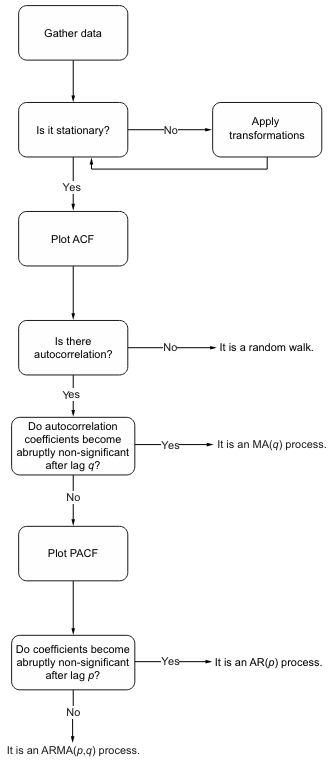

So ARMA(p, q) is when the data is not MA nor AR process them self but it is a combination of both. Optimal values for p and q is determined by Akaike Information Criterion (AIC). So ARMA is a combination of MA and AR method.
Lets consider we have a time series with simulation below:
yt= 0.33yt –1 + 0.9ϵt –1 + ϵt

###Data Generation

In [ ]:
from statsmodels.tsa.arima_process import ArmaProcess
import numpy as np
np.random.seed(42)
ar1 = np.array([1, -0.33])
ma1 = np.array([1, 0.9])
ARMA_1_1 = ArmaProcess(ar1, ma1).generate_sample(nsample=1000)

###Check If Stationary

In [ ]:
from statsmodels.tsa.stattools import adfuller
ADF_result = adfuller(ARMA_1_1)
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -6.429878682042695
p-value: 1.707846668009654e-08


Since we have a large negative ADF statistic and a p-value that’s much smaller than 0.05, we can conclude that our simulated ARMA(1,1) process is stationary.

###ACF Visualization

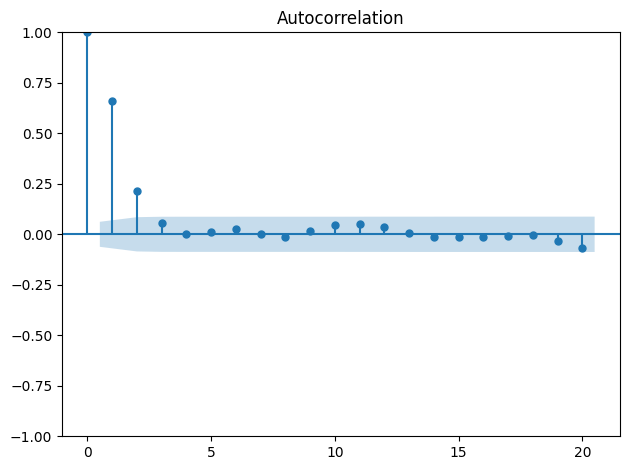

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

%matplotlib inline

plot_acf(ARMA_1_1, lags=20);
plt.tight_layout()

We made MA(1) but here we see q=2. On the  other hand we can see a sinusoidal pattern as well. So PACF plotting is neccessary here.

###PACF Visualization

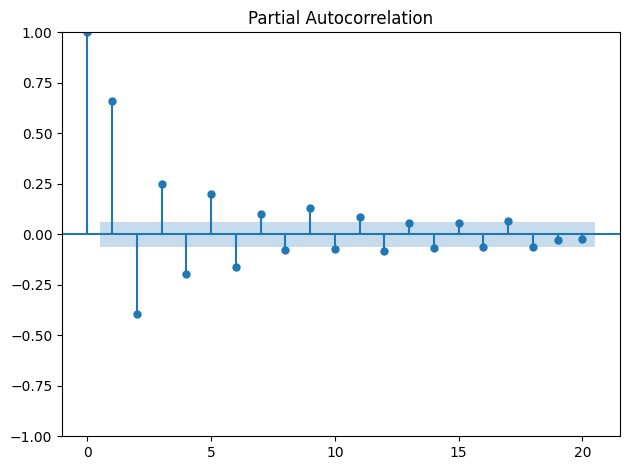

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(ARMA_1_1, lags=20);
plt.tight_layout()

we can see a clear sinusoidal pattern, meaning that we cannot infer a
value for the order p. Neither plot was useful for determining the orders p and q.  Therefore, we must devise a procedure that allows us to find the orders p and q.
This procedure will have the advantage that it can also be applied in situations where
our time series is non-stationary and has seasonal effects.This leads to another guidline below:

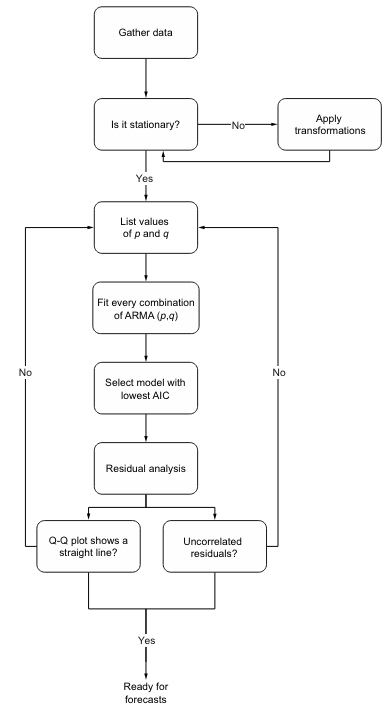

 you can see that this new modeling procedure completely removes
the plotting of the ACF and PACF. It allows us to select a model based entirely on statistical tests and numerical criteria, instead of relying on the qualitative analysis of the
ACF and PACF plots.we can analyze the model’s residuals, which is the difference between
the actual and predicted values of the model. Ideally, the residuals will look like white
noise, which would mean that any difference between the predicted values and actual
values is due to randomness. Therefore, the residuals must be uncorrelated and independently distributed.

Here it comes AIC: Akaike information criterion (AIC)

The Akaike information criterion (AIC) is a measure of the quality of a model in relation to other models. It is used for model selection.
The AIC is a function of the number of parameters k in a model and the maximum
value of the likelihood function L:

AIC = 2k - 2ln(L)

The lower the value of the AIC, the better the model. Selecting according to the AIC
allows us to keep a balance between the complexity of a model and its goodness of
fit to the data.

Now lets go for "List values for p and q":

###p&q:

In [ ]:
from itertools import product
ps = range(0, 4, 1)
qs = range(0, 4, 1)
order_list = list(product(ps, qs))

###Fit All ARMA Models

In [ ]:
from typing import Union
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd

def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:

  results = []

  for order in tqdm_notebook(order_list):
    try:
      model = SARIMAX(endog, order=(order[0], 0, order[1]),
                      simple_differencing=False).fit(disp=False)
    except:
      continue

    aic = model.aic
    results.append([order, aic])

  result_df = pd.DataFrame(results)
  result_df.columns = ['(p,q)', 'AIC']

  #Sort in ascending order, lower AIC is better
  result_df = result_df.sort_values(by='AIC',
                                    ascending=True).reset_index(drop=True)

  return result_df

In [ ]:
result_df = optimize_ARMA(ARMA_1_1, order_list)
result_df

<ipython-input-16-5391e08df6b9>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for order in tqdm_notebook(order_list):


  0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,"(p,q)",AIC
0,"(1, 1)",2801.407785
1,"(2, 1)",2802.906070
2,"(1, 2)",2802.967762
3,"(0, 3)",2803.666793
4,"(1, 3)",2804.524027
5,"(3, 1)",2804.588567
6,"(2, 2)",2804.822282
7,"(3, 3)",2806.162939
8,"(2, 3)",2806.175380
9,"(3, 2)",2806.894930


Now the best model here is (1, 1) but AIC is a good measure for comparing models not their absolute performance: So we go for residual analysis. There are two ways to do this:

###QUALITATIVE ANALYSIS: STUDYING THE Q-Q PLOT

The Q-Q plot is a graphical tool for verifying our hypothesis that the model’s residuals
are normally distributed.


A Q-Q plot is a plot of the quantiles of two distributions against each other. In time
series forecasting, we plot the distribution of our residuals on the y-axis against the
theoretical normal distribution on the x-axis.
This graphical tool allows to us to assess the goodness of fit of our model. If the distribution of our residuals is similar to a normal distribution, we will see a straight line
lying on y = x. This means that our model is a good fit, because the residuals are
similar to white noise.
On the other hand, if the distribution of our residuals is different from a normal distribution, we will see a curved line. We can then conclude that our model is not a good
fit, since the residuals’ distribution is not close to a normal distribution, and therefore
the residuals are not similar to white noise.

###QUANTITATIVE ANALYSIS: APPLYING THE LJUNG-BOX TEST


The Ljung-Box test is a statistical test that determines whether the autocorrelation of
a group of data is significantly different from 0.
In time series forecasting, we apply the Ljung-Box test on the model’s residuals to
test whether they are similar to white noise. The null hypothesis states that the data
is independently distributed, meaning that there is no autocorrelation. If the p-value
is larger than 0.05, we cannot reject the null hypothesis, meaning that the residuals
are independently distributed. Therefore, there is no autocorrelation, the residuals
are similar to white noise, and the model can be used for forecasting.
If the p-value is less than 0.05, we reject the null hypothesis, meaning that our residuals are not independently distributed and are correlated. The model cannot be used
for forecasting.


In [27]:
model = SARIMAX(ARMA_1_1, order=(1,0,1), simple_differencing=False)
model_fit = model.fit(disp=False)
residuals = model_fit.resid

###Q-Q plot

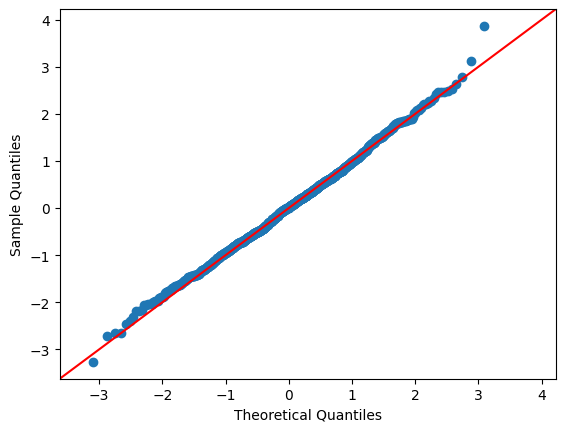

In [28]:
from statsmodels.graphics.gofplots import qqplot
qqplot(residuals, line='45');

You will see a thick straight line that approximately
lies on y = x. Therefore, from a qualitative standpoint, the model’s residuals seem to
be normally distributed, just like white noise, which is an indication that our model
fits the data well.

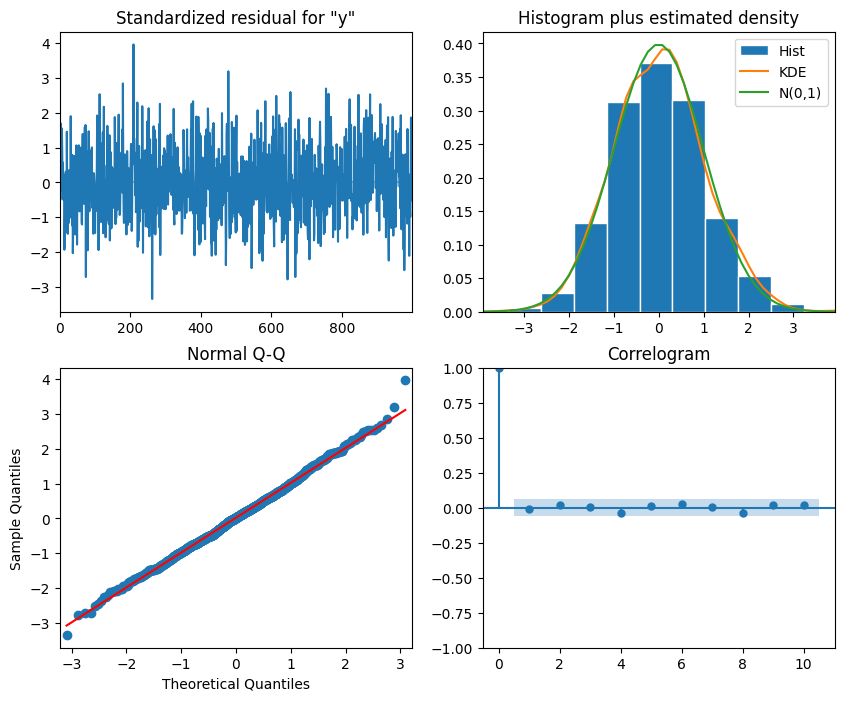

In [29]:
model_fit.plot_diagnostics(figsize=(10, 8));

###Ljung-Box test

In [31]:
from statsmodels.stats.diagnostic import acorr_ljungbox

df = acorr_ljungbox(residuals, np.arange(1, 11, 1), return_df=True)

print(df)

     lb_stat  lb_pvalue
1   0.030706   0.860897
2   0.528021   0.767966
3   0.540904   0.909817
4   2.079774   0.721089
5   2.271897   0.810385
6   2.896262   0.821750
7   2.900378   0.894063
8   4.418799   0.817501
9   4.787567   0.852419
10  5.246805   0.874093


All p values are above 0.5 meaning that the residuals are independently distributed and uncorrelated.


Now lets try to predict something:

In [54]:
train = ARMA_1_1[:int(0.9*len(ARMA_1_1))]
test = ARMA_1_1[int(0.9*len(ARMA_1_1)):]

###Rolling Forecast Function

In [55]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int,
                     window: int, method: str) -> list:

  total_len = train_len + horizon
  end_idx = train_len

  if method == 'mean':
    pred_mean = []

    for i in range(train_len, total_len, window):
      mean = np.mean(df[:i].values)
      pred_mean.extend(mean for _ in range(window))

    return pred_mean
  elif method == 'last':
    pred_last_value = []

    for i in range(train_len, total_len, window):
      last_value = df[:i].iloc[-1].values[0]
      pred_last_value.extend(last_value for _ in range(window))
    return pred_last_value
  elif method == 'ARMA':
    pred_ARMA = []

    for i in range(train_len, total_len, window):
      model = SARIMAX(df[:i], order=(2,0,2))
      res = model.fit(disp=False)
      predictions = res.get_prediction(0, i + window - 1)
      oos_pred = predictions.predicted_mean.iloc[-window:]
      pred_ARMA.extend(oos_pred)

    return pred_ARMA

In [56]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2
df_diff = pd.DataFrame(ARMA_1_1, columns=['value'])
pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW,'last')
pred_ARMA = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'ARMA')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/st

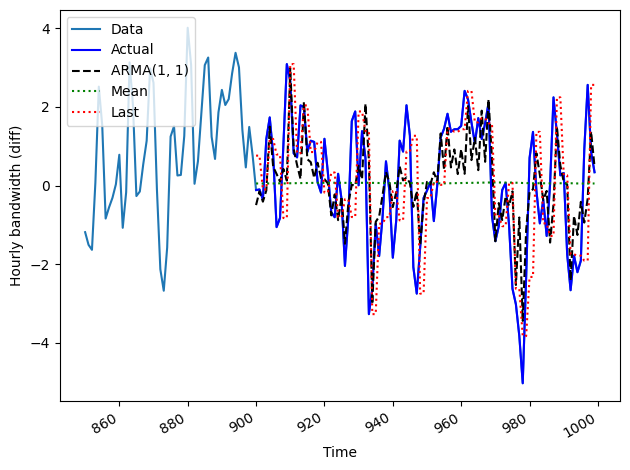

In [58]:
fig, ax = plt.subplots()
n_last = 150
x_idx = np.arange(len(ARMA_1_1) - n_last, len(ARMA_1_1))
ax.plot(x_idx, ARMA_1_1[-n_last:], label='Data')
ax.plot(x_idx[-len(test):], test, 'b-', label='Actual')
ax.plot(x_idx[-len(pred_ARMA):], pred_ARMA, 'k--', label='ARMA(1, 1)')
ax.plot(x_idx[-len(pred_mean):], pred_mean, 'g:', label='Mean')
ax.plot(x_idx[-len(pred_last_value):], pred_last_value, 'r:', label='Last')
ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwidth (diff)')
fig.autofmt_xdate()
plt.tight_layout()


In [60]:
from sklearn.metrics import mean_squared_error
mse_mean = mean_squared_error(test, pred_mean)
mse_last = mean_squared_error(test, pred_last_value)
mse_arma = mean_squared_error(test, pred_ARMA)
print(mse_mean)
print(mse_last)
print(mse_arma)

2.5261101769611307
2.6313289083235794
1.3922175162197215
